## Task 2: Provide an analysis of marine heatwaves over a region

In this task you will learn to use sea surface temperature (SST) data to define and analyse marine heatwaves (MHWs) in the Mediterranean region. You will learn how the selection of different sources and time periods of SST data impacts the definition, and therefore analysis, of MHWs. Specifically, you will:

* Learn the definition of MHWs following [Hobday et al (2016)](https://www.sciencedirect.com/science/article/abs/pii/S0079661116000057);
* Learn to reduce bias when looking at different sources and slices of SST data;
* Understand the impact that different SST data has on the detection of MHWs;
* Understand how the choice of SST data impacts the stability of trends and climatology.

This task is based in python. While you don't need to understand python to follow the course, you need to know how to install python packages, and how to use a Jupyter notebook to run given python code. Some optional exercises will require modification of certain parameters in given code, and guidance will be provided in those cases. For those interested, optional extra sections will give deeper explanations on how some code snippets function.

This task is split into seven main lessons. Before the first lesson, the getting setup page will help you setup your Jupyter notebook with the required python packages, and then download the data we will require for this task.

#### Getting setup

**Setting up the Jupyter notebook and importing packages**

In [1]:
import xarray as xr
import os
import json
import datetime
import glob
from pydap.client import open_url
from pydap.cas.get_cookies import setup_session
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import pandas as pd     
from scipy import stats    
from xmhw.xmhw import threshold, detect

**Downloading data**

The data for this notebook will be downloaded from the Copernicus Marine Environment Monitoring Service (CMEMS) datastore. A free account is required to access the datastore, and can be created [here](https://data.marine.copernicus.eu/register). Make a note of your username and password.

*The steps to download data outlined here will become deprecated from March 2024 due to updates to the CMEMS datastore. The course will be updated once the required data can be stably accessed via the python API.*

We will download all the data we need from the CMEMS datastore straight to this notebook. We will use the following function to set up a session with the datastore. Copy the cell, and change the `username` and `password` fields to your CMEMS username and password, each surrounded by quotes. For example, if your username is username, then write `username = "username"`. Make sure you run the cell before continuing.

In [2]:
# Hidden cell for use with locally stored credentials.
def read_credentials_file(authentication_url, credentials_file):
    with open(credentials_file) as json_file:
        credentials = json.load(json_file)
        username, password = credentials[authentication_url]
        return username, password

In [3]:
# Hidden cell for use with locally stored credentials.
# Authenticate a session and access the Copernicus datastore
def copernicus_datastore(authentication_url, dataset, credentials_file):
    '''
    This function authenticates the CMEMS Data Store
    '''
    username, password = read_credentials_file(authentication_url, credentials_file)
    session = setup_session(uri = 'https://cmems-cas.cls.fr/cas/login', username = username,password = password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    data_store = xr.backends.PydapDataStore(open_url(f'{authentication_url}/thredds/dodsC/{dataset}', session = session))
    return data_store

In [4]:
def copernicus_datastore(authentication_url, dataset, credentials_file):
    '''
    This function authenticates the CMEMS Data Store
    '''
    # EDIT THE FOLLOWING FIELDS WITH YOUR CREDENTIALS
    username = "enter username" # change to your CMEMS datastore username, surrounded by quotes
    password = "enter password" # change to your CMEMS datastore password, surrounded by quotes
    
    session = setup_session(uri = 'https://cmems-cas.cls.fr/cas/login', username = username,password = password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    data_store = xr.backends.PydapDataStore(open_url(f'{authentication_url}/thredds/dodsC/{dataset}', session = session))
    return data_store

Marine heatwaves are defined based on sea surface temperature (SST) data and climatology. The main dataset we will use is the [OSTIA Reprocessed SST](https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/description) dataset - from now on referred to as the MY (multi year) dataset. This product became deprecated in October 2022.

With a forward view, we will also examine the [OSTIA NRT SST](https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001/description) dataset - from now on referred to as the NRT dataset - which contains up-to-date measurements. As part of this task, we will compare the two datasets and review the caveats in using NRT data to define a climatology.

This next cell defines the parameters of which datasets we will access and where we will store them. We will use two sources of SST data.
The MY dataset runs from 1982 until 2021, while the NRT dataset runs from 2007 to the present day. We'll download all the data available from both datasets between 1982 (`start_year`) and 2023 (`end_year`).

Our region of interest (ROI) is the Mediterranean region. We'll access the data by defining a rough geographic bounding box around a small region between 36 and 42 degrees north, and 10 and 15 degrees east. This data contained in the `TS_region` parameter.

In [5]:
# Create a download directory for our OLCI products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

# Data downloading options
download_cmems_data = True # Change to False once data has been dowloaded
cmems_credentials_file = os.path.join(os.path.expanduser("~"),'.cmems_opendap')

tags = ["MY", "NRT"]

# Multi-year reprocessing
authentication_url_my = 'https://my.cmems-du.eu'
dataset_my = 'METOFFICE-GLO-SST-L4-REP-OBS-SST'
format_my = 'CLIM_OSTIA_SST_'

# Near real-time
authentication_url_nrt = 'https://nrt.cmems-du.eu'
dataset_nrt = 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2'
format_nrt = 'OPER_OSTIA_SST_'

# L4 Time series ROI
TS_region = [10, 36, 15, 42] # W, S, E, N

# climatology
start_year = 1982
end_year = 2023

The next cell actually downloads the data. For each dataset and for data found within the region of interest, it creates a time series by computing daily average SST across the region. **Be aware that this cell will take around 15 minutes to run!** As it is running, it prints a progress message each for each year it completes. To prevent it from accidentally running again, it is recommended to change the parameter `download_cmems_data` in the previous cell from `True` to `False`.

In [6]:
# Download time series.
if download_cmems_data:
    for authentication_url, dataset, tag in zip([authentication_url_my, authentication_url_nrt], [dataset_my, dataset_nrt], tags):
        data_store = copernicus_datastore(authentication_url, dataset, cmems_credentials_file)
        DS = xr.open_dataset(data_store)
        
        # For each selected year, download and store any available data.
        for iter_year in range(start_year, end_year):
            try:
                dateStart = datetime.datetime(iter_year, 1, 1).strftime('%Y-%m-%d')
                dateEnd = (datetime.datetime(iter_year+1, 1, 1) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
                print(f"Getting time series for {dataset}, {iter_year} to {iter_year+1}")
                TS = DS.analysed_sst.sel(lon=slice(TS_region[0], TS_region[2]), lat=slice(TS_region[1], TS_region[3]))\
                                    .sel(time=slice(f"{dateStart}", f"{dateEnd}"))\
                                    .mean(dim=["lon", "lat"])
                if iter_year == end_year or len(TS) >= 365:
                    TS.to_netcdf(os.path.join(download_dir,f"TS_{iter_year}_{tag}.nc"))
            except:
                print(f"No times available for {dataset}")
    
        DS.close()
        data_store.close()

**Storing data in a dictionary**

Once all the data has been downloaded, the final step to getting setup is to store the data. Throughout this task, we'll build up a dictionary `heatwaves` which will keep track of all the data we generate. We'll start by creating sub-dictionaries `heatwaves["MY"]` and `heatwaves["NRT"]` and storing the MY and NRT data in the respective `"dataset"` attribute of each.

In [7]:
heatwaves = {}
for tag in tags:
    heatwaves[tag] = {}
    TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
    DS = xr.open_mfdataset(TS_files)
    heatwaves[tag]["dataset"] = DS
    DS.close()

If you ever get lost, use the `keys()` function to access what each part of the dictionary stores. For example:

In [8]:
print(heatwaves.keys())
print(heatwaves["MY"].keys())

dict_keys(['MY', 'NRT'])
dict_keys(['dataset'])


#### Lesson 1: Marine heatwaves

The goal of this task is to analyse marine heatwaves (MHWs) for a given set of sea surface temperature (SST data). We will follow the definition given by [Hobday et al. (2016)](https://www.sciencedirect.com/science/article/abs/pii/S0079661116000057). The linked paper gives justifications for parameter choices in the definition, as well as defining characteristics of MHWs such as intensity and onset rate. These characteristics are not covered in this course, but you will be able to analyse them using the tools covered.


**Definition**

Marine heatwaves are defined by having all three of the following three features.

**Anomalously warm period**

An anomalously warm period is defined as when recorded temperature is above a percentile threshold of given climate data.
* The suggested percentile is 90%.
* This avoids assumptions about the distribution of anomalies, unlike standard deviation.
* The definition depends on the choice of climatology.

**Prolonged period**

The temperature must remain above the threshold for a certain number of days to be considered as a heatwave.
* The suggested duration is 5 days. This is set to balance the detection of heatwaves in tropical locations (elevated with shorter duration) and in cooler locations (disproportionately diminished with longer duration).

**Discrete period**

A period of cooler days must exist between two periods of elevated temperatures to distinguish them as different heatwaves.
*The suggested period is 2 days.

#### Lesson 2

**MY data climatology**

The `xmhw` python package contains all the functionality we need to detect and analyse MHWs. We will first use it to generate climatologies for our datasets. The `xmhw` function `threshold` computes the climatology for a given time series `TS` and stores it as the attribute `threshold(TS).seas`. For further discussion of how the climatology is computed in this package, along with some of the options, please see "Detail on climatology" section below.

The following cell generates climatology for the MY dataet.

In [9]:
clim_start_year = start_year
clim_end_year = end_year

tag = "MY"

heatwaves[tag]["full"] = {}
working_dict = heatwaves[tag]["full"]

working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31')) - 273.15
working_dict["start_year"] = working_dict["time_series"][0].time.dt.year.values
working_dict["end_year"] = working_dict["time_series"][-1].time.dt.year.values
working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])

The following cell then plots the generated climatology.

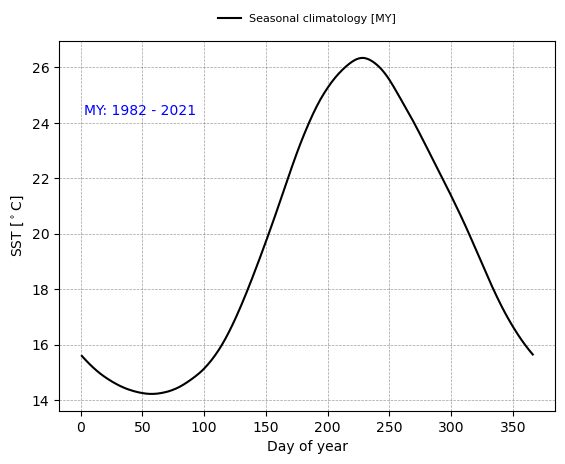

In [10]:
tag = "MY"

plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].seas, c = "k")
plots.append(p)
labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

By changing the tag to `NRT` we can obtain the full climatology for NRT data. Over the next few lessons we will compare the NRT and MY climatologies generated from different time periods.

**NRT data climatology**

Repeat the previous steps for the NRT dataset by changing the `tag` parameter in each of the two code cells to `tag = "NRT"` and run both cells again. Alternatively, you can run the following code as a new cell.

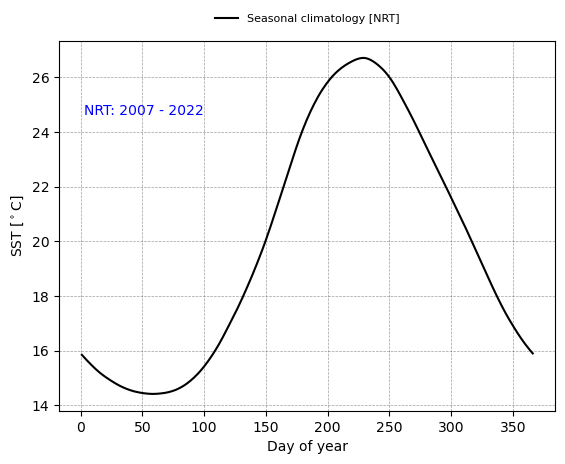

In [11]:
clim_start_year = start_year
clim_end_year = end_year

tag = "NRT"

heatwaves[tag]["full"] = {}
working_dict = heatwaves[tag]["full"]

working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31')) - 273.15
working_dict["start_year"] = working_dict["time_series"][0].time.dt.year.values
working_dict["end_year"] = working_dict["time_series"][-1].time.dt.year.values
working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])

plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].seas, c = "k")
plots.append(p)
labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

**Detail on climatology**

The `xmhw` package computes mean climatology through using a rolling average as a smoothing method. As the day of year (DoY) varies, a rolling average is taken using a window of data centred on the DoY of width `31`. This parameter can be changed to any odd number n when calling the `xmhw.threshold` function by passing the keyword argument `smoothPercentileWidth = n`.

The following cell creates two mean climatologies using the full period of the MY dataset: `thresh_1` with the default window length of `31`, and `thresh_2` with a shortened length of `7`.


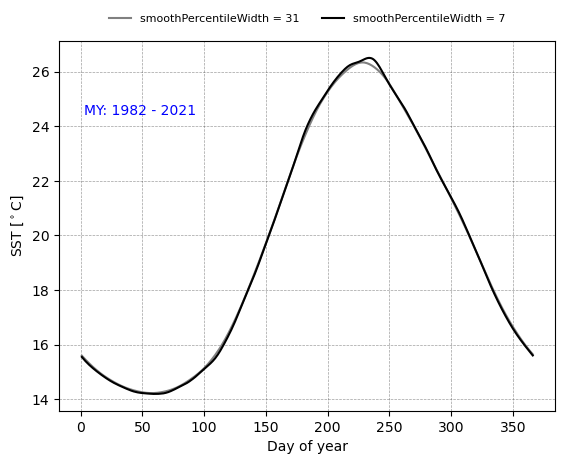

In [12]:
tag = "MY"
series = "full"

working_dict = heatwaves[tag][series]

thresh_1 = threshold(working_dict["time_series"], smoothPercentileWidth = 31) # default window width of 31
thresh_2 = threshold(working_dict["time_series"], smoothPercentileWidth = 7) # window width of 7

plots = []; labels = []; annot = ""

p, = plt.plot(thresh_1.doy, thresh_1.seas, c = "grey")
plots.append(p)
labels.append(f"smoothPercentileWidth = 31")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

q, = plt.plot(thresh_2.doy, thresh_2.seas, c = "k")
plots.append(q)
labels.append(f"smoothPercentileWidth = 7")

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

While the difference is subtle, you can see that the plot corresponding to `thresh_2` is certainly less smooth, particularly around the maximum and minimum temperatures. Try changing the parameter `smoothPercentileWidth` for `thresh_2` up to 183 (half a year) or even 365 (full year). You should see that the seasonal highs and lows are smoothed out.

Marine heatwaves should be sensitive to seasonal climatology (Hobday et al.), that is they should be detected in both cooler and warmer periods of the year. Is the default value of `smoothPercentileWidth = 31` a good choice to achieve this?

#### Lesson 3: Comparing climatologies



**Comparing climatologies**

The following code cell will plot the climatologies we generated from the MY and NRT data on the same axes.

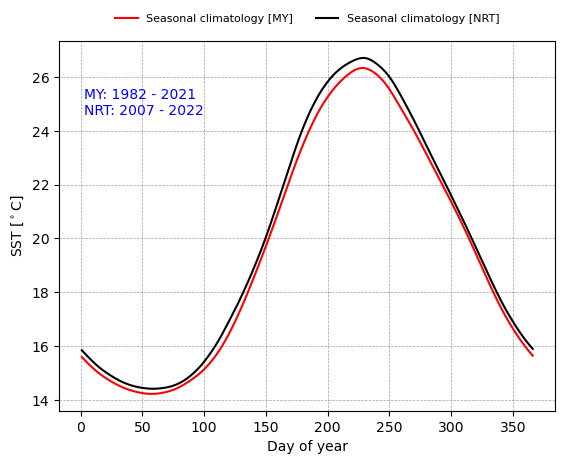

In [13]:
clim_start_year = start_year
clim_end_year = end_year
plots = []; labels = []; annot = ""

for tag, plot_col in zip(["MY", "NRT"], ["r", "k"]):
    working_dict = heatwaves[tag]["full"]
    p, = plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()



**Reducing bias in comparisons**

In the previous section, we saw that it is easy to make a biased conclusion when doing quick comparisons between datasets. A good rule to reduce the chance of bias is to ensure that you produce plots or analyses between things by changing only one parameter. That way, you can more clearly see what is going on. 

In the previous section, we plotted mean climatologies produced from **two** different datasets generated over **two** different time periods. The next cell addresses this by fixing a common reference period between the datasets, in this case 2007 - 2021.

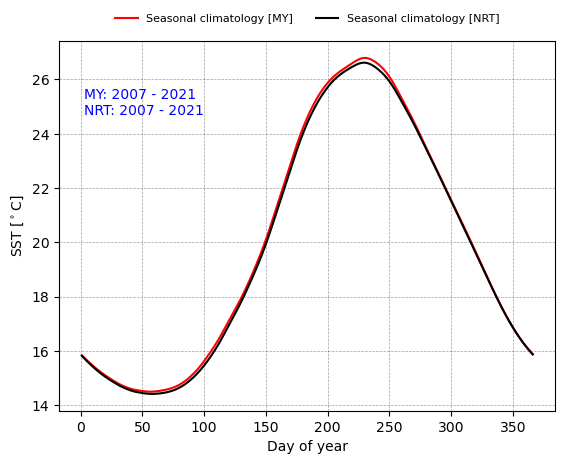

In [14]:
clim_start_year = 2007
clim_end_year = 2021

plots = []; labels = []; annot = ""

for tag, plot_col in zip(["MY", "NRT"], ["r", "k"]):
    heatwaves[tag]["common"] = {}
    working_dict = heatwaves[tag]["common"]
    working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31')) - 273.15
    working_dict["start_year"] = working_dict["time_series"][0].time.dt.year.values
    working_dict["end_year"] = working_dict["time_series"][-1].time.dt.year.values
    working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])

    clim = working_dict["xmhw_thresh"]
    p, = plt.plot(clim.doy, clim.seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

We observe that this plot shows that MY climatology is now higher than NRT climatology over the common reference period of 2007-2021.

**Confirming observations with analysis**

On closer examination, the difference between the two plots produced in this lesson is down to a large shift in climatology in the MY dataset, depending on if it is defined over the period from 1982-2021, or the shorter period 2007-2021. In particular, including the longer history in resulted in lower average temperatures being calculated. The following cell will produce a plot helping to visualise the differences:

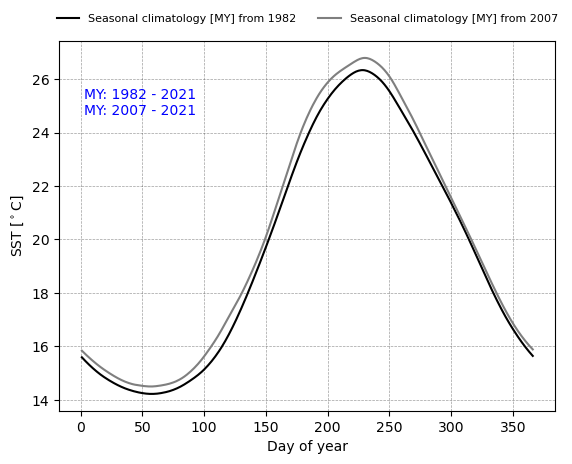

In [15]:
plots = []; labels = []; annot = ""
tag = "MY"

for series, plot_col in zip(["full", "common"], ["k", "tab:gray"]):
    working_dict = heatwaves[tag][series]
    p, = plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}] from {working_dict['start_year']}")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"   


plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

What these plots don't show, however, is what has caused the difference between the two climatologies: all they tell us is that average temperatures in the period 1982-2021 were lower than in the period 2007-2021. Is this due to an upward trend in temperatures, or were there simply some very cold years in the period 1982-2006 which dragged down the full climatology?

Our intuition and experience tells us that it should be the former. Let's test that by performing a regression analysis on the full MY time series data. The following cell does exactly that.

Trend - R-squared (pvalue): 0.033366 K/year - 0.693825 (0.000000)


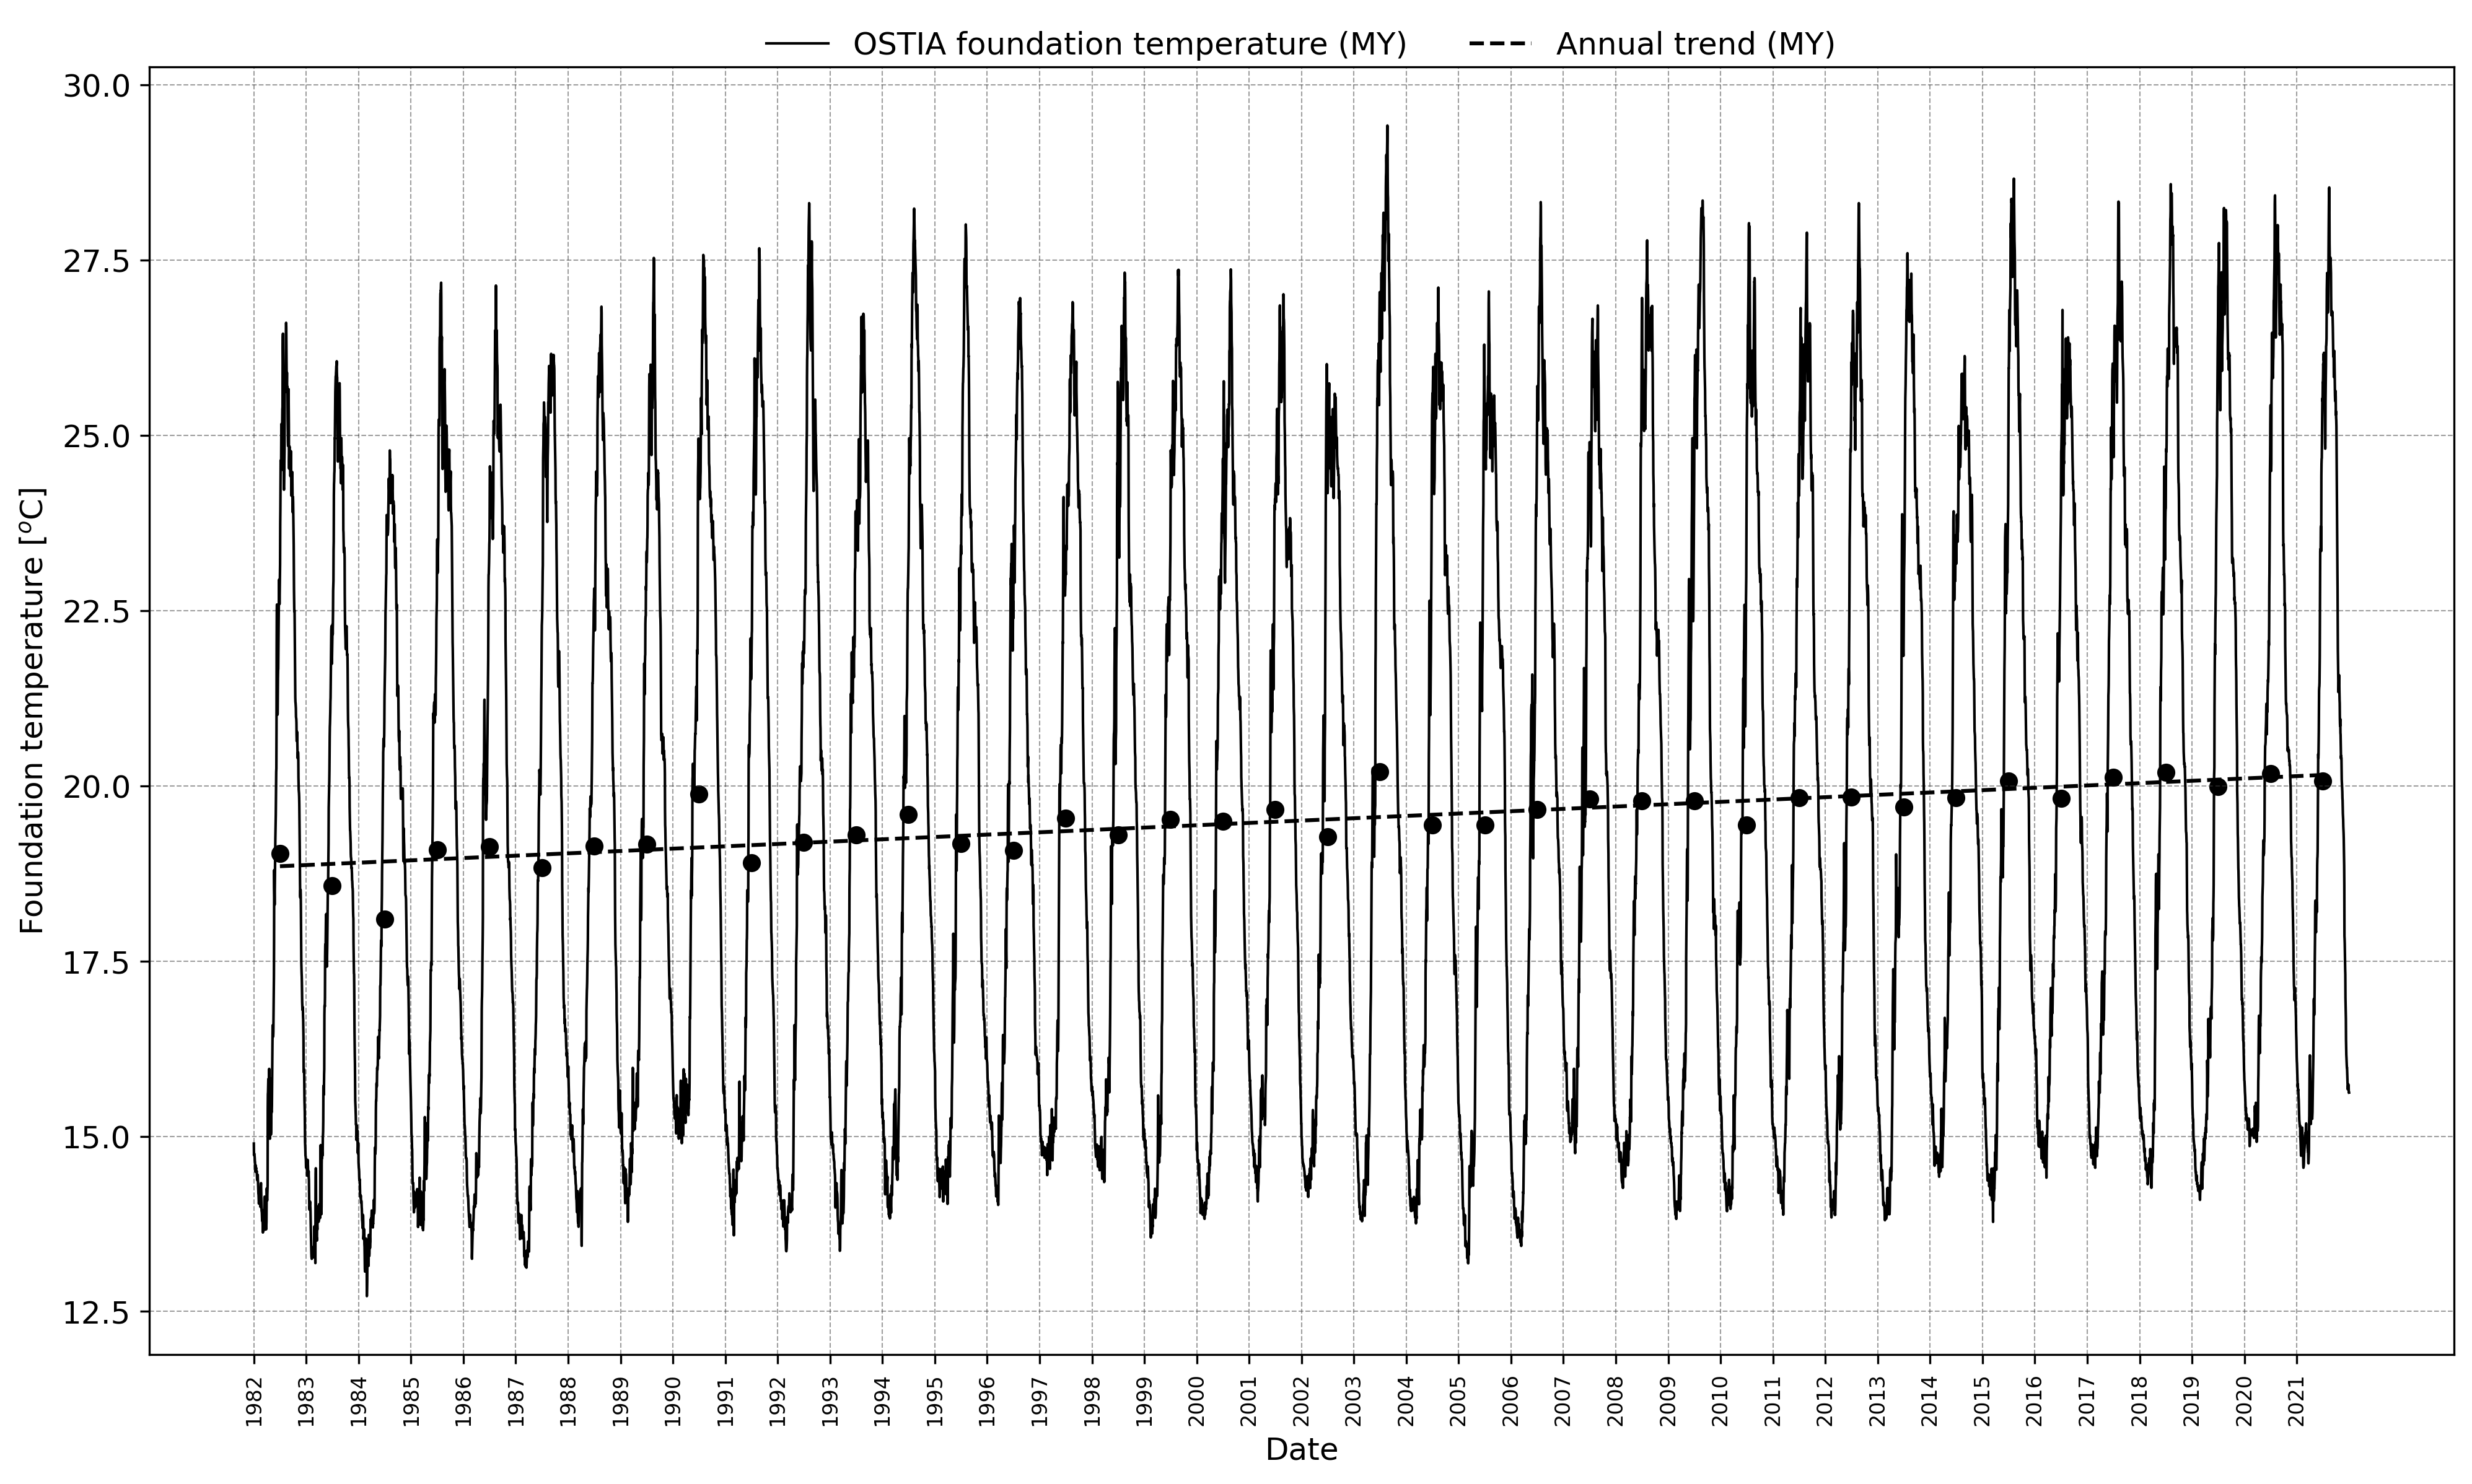

In [16]:
# setup figure
fig = plt.figure(figsize=(16, 9), dpi=300)
plt.rc('font', size=12)

plots = [] ; labels = []; xticks = []; xtick_labels= []

clim_start_year = start_year
clim_end_year = end_year

for tag, plot_colour in zip(["MY"], ["k"]):
    TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
    
    DS = xr.open_mfdataset(TS_files).sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31'))
    DS["timeordinal"]=(['time'],  [pd.to_datetime(x).toordinal() for x in DS.time.values])

    p1, = plt.plot(DS.timeordinal, DS.analysed_sst - 273.15, linewidth=1, c=plot_colour)
    plots.append(p1)
    labels.append(f"OSTIA foundation temperature ({tag})")

    # calculate trend
    annual = DS.groupby('time.year').mean('time')
    res = stats.linregress(annual.timeordinal, annual.analysed_sst - 273.15)
    plt.scatter(annual.timeordinal, annual.analysed_sst - 273.15, c=plot_colour)
    p2, = plt.plot(annual.timeordinal, res.intercept + res.slope*annual.timeordinal,
                   color=plot_colour, linestyle="--", label='fitted line')
    plots.append(p2)
    labels.append(f"Annual trend ({tag})")
    xticks.append([datetime.datetime(ii.data, 1, 1).toordinal() for ii in  annual.year])
    xtick_labels.append(annual.year)
    print(f"Trend - R-squared (pvalue): {res.slope*365:.6f} K/year - {res.rvalue**2:.6f} ({res.pvalue**2:.6f})")

plt.xticks(np.array([item for sublist in xticks for item in sublist]),
           labels=np.array([item for sublist in xtick_labels for item in sublist]),
           rotation=90, fontsize=8)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
legend = plt.legend(plots, labels, frameon=False, bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=4)
plt.xlabel("Date")
plt.ylabel("Foundation temperature [$^{o}$C]")

plt.show()

This analysis indicates upward trend in SST data over the past 40 years, with an average warming rate of 0.033366 degrees per year.

The regression analysis also outputs a `pvalue` parameter, the result of a significance test on the regression calculation. For a discussion of this, see significance testing.

#### Lesson 4: Detecting marine heatwaves

In this lesson, we will use our generated climatologies to detect marine heatwaves from time series data. Specifically, we will:

* Learn the process of plotting the MHW detection threshold for a given climatology;
* Learn to produce plots demonstrating the detection of MHWs.

Optional additional tasks will help you appreciate how the detection of MHWs change by changing parameters associated to the definition, such as the detection threshold.

**Plotting detection thresholds**

Recall that MHWs are defined when recorded temperatures passes above a threshold defined from a certain percentile of climatology data.

We used the `xmhw` function `threshold` to produce mean climatologies from time series data. This function also produces the detection threshold. For further discussion of how this function works and how to adjust the detection threshold, see the "Detail on thresholds" section below.

The following cell plots the climatology and detection threshold for the full series of MY data.

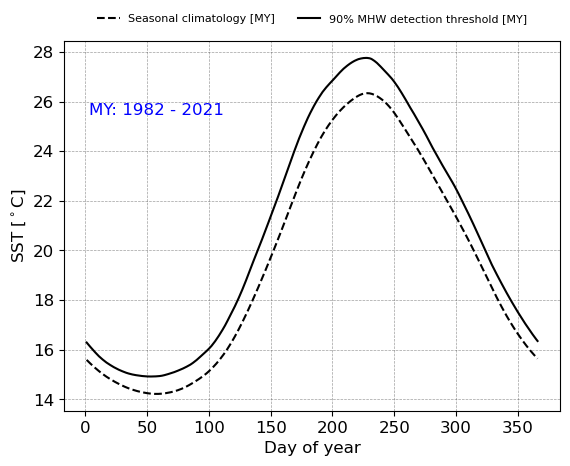

In [17]:
tag = "MY" #or "NRT"
series = "full" #or "common"

working_dict = heatwaves[tag][series]

plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].seas, c = "k", linestyle = '--')
plots.append(p)
labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

q, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].thresh, c = "k")
plots.append(q)
labels.append(f"90% MHW detection threshold [{tag}]")

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

You can get a feel of the different thresholds by changing `tag` between `"MY"` and `"NRT"`, and `series` between `"full"` and `"common"`.

**Superimposing time series data**

Next, we will plot our climatology and threshold against the actual time series data. To do this, it will help to be able to more easily create slices of time series data, which the following function does. If `end_year` is left blank, it will produce a single year slice.

In [18]:
def create_TS_slice(tag, series_name, start_year, end_year = None):
    heatwaves[tag][series_name] = {}
    working_dict = heatwaves[tag][series_name]
    working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{start_year}-01-01', f'{end_year or start_year}-12-31')) - 273.15
    working_dict["start_year"] = start_year
    working_dict["end_year"] = end_year or start_year

Let's create a slice of the MY dataset over its most recent 5 years of recording, 2016-2021, and save it under the series name `"2017-2021"`. We'll then plot this slice against the full MY climatology and threshold.

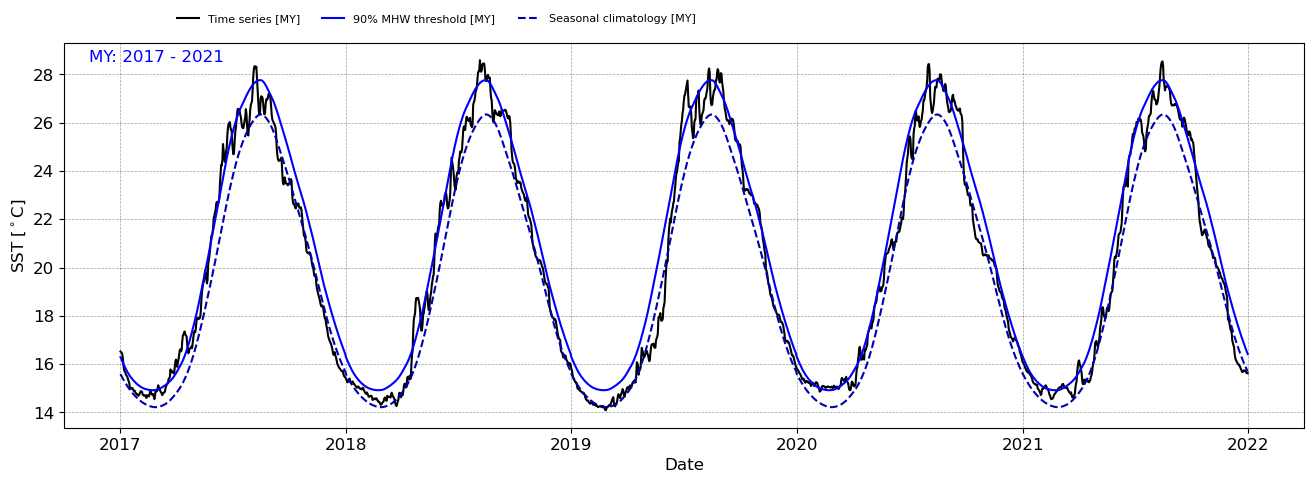

In [19]:
tag = "MY"
series_name = "2017-2021"

create_TS_slice(tag, series_name, 2017, 2021)

working_dict = heatwaves[tag][series_name]
clim_dict = heatwaves[tag]["full"]

plt.figure(figsize=(16, 5))
plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["time_series"].time, working_dict["time_series"], c = "k")
q, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].thresh[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,1))
r, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].seas[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,0.7), linestyle = "--")
plots.append(p); plots.append(q); plots.append(r)
labels.append(f"Time series [{tag}]"); labels.append(f"90% MHW threshold [{tag}]"); labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.3, 1.10), loc='upper center', ncol=3, fontsize=8)
plt.annotate(annot, (0.02, 0.95), xycoords="axes fraction", color='b')
plt.xlabel(r'Date')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()


Looking at the plot, we see some clear candidates for heatwaves, the first being in early 2017. Additionally, there are spikes in each summer. It is not clear, however, whether these satisfy the *prolonged period* part of the definition of a MHW. In the next section, we will use the `xmhw` package to help us detect which of these candidates are heatwaves.

**Detecting marine heatwaves**

The `xmhw` package contains functionality to detect heatwaves. For a given time series `TS`, climatology `clim` and detection threshold `thresh`, the function `detect(TS, thresh, clim)` produces an object storing all detected heatwaves according to the definition. For more information on this object, as well as how to change some of the parameters used for detection, such as the required duration, see the "Detail on MHW detection" section below.

Let's see the `detect` function in action for the above example.

In [20]:
tag = "MY"
series_name = "2017-2021"

working_dict = heatwaves[tag][series_name]
clim_dict = heatwaves[tag]["full"]

mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

mhw_start_times = mhws.time_start.values.astype("datetime64[D]").tolist()
mhw_end_times = mhws.time_end.values.astype("datetime64[D]").tolist()
mhw_number = min(len(mhw_start_times), len(mhw_end_times))

for i in range(mhw_number):
    start = mhw_start_times[i]
    end = mhw_end_times[i]
    print(f"Heatwave {i+1} of {mhw_number}: \n start: {start.year}-{start.month}-{start.day}, end: {end.year}-{end.month}-{end.day}")

Heatwave 1 of 26: 
 start: 2017-3-19, end: 2017-4-19
Heatwave 2 of 26: 
 start: 2017-5-31, end: 2017-6-6
Heatwave 3 of 26: 
 start: 2017-6-11, end: 2017-6-30
Heatwave 4 of 26: 
 start: 2017-8-4, end: 2017-8-10
Heatwave 5 of 26: 
 start: 2018-4-20, end: 2018-5-1
Heatwave 6 of 26: 
 start: 2018-5-30, end: 2018-6-6
Heatwave 7 of 26: 
 start: 2018-8-2, end: 2018-8-22
Heatwave 8 of 26: 
 start: 2018-9-10, end: 2018-9-25
Heatwave 9 of 26: 
 start: 2019-6-25, end: 2019-7-13
Heatwave 10 of 26: 
 start: 2019-8-23, end: 2019-9-5
Heatwave 11 of 26: 
 start: 2019-9-16, end: 2019-9-22
Heatwave 12 of 26: 
 start: 2019-9-26, end: 2019-10-3
Heatwave 13 of 26: 
 start: 2019-10-25, end: 2019-11-6
Heatwave 14 of 26: 
 start: 2020-1-31, end: 2020-2-5
Heatwave 15 of 26: 
 start: 2020-2-10, end: 2020-3-6
Heatwave 16 of 26: 
 start: 2020-3-11, end: 2020-3-21
Heatwave 17 of 26: 
 start: 2020-4-9, end: 2020-4-13
Heatwave 18 of 26: 
 start: 2020-7-29, end: 2020-8-3
Heatwave 19 of 26: 
 start: 2020-8-19, end: 20

You will see an output showing the dates of 26 detected heatwaves in the 2017-2021 period. The following cell makes these dates easier to visualise, by shading the time periods in which heatwaves were detected on the plot produced in the previous section.

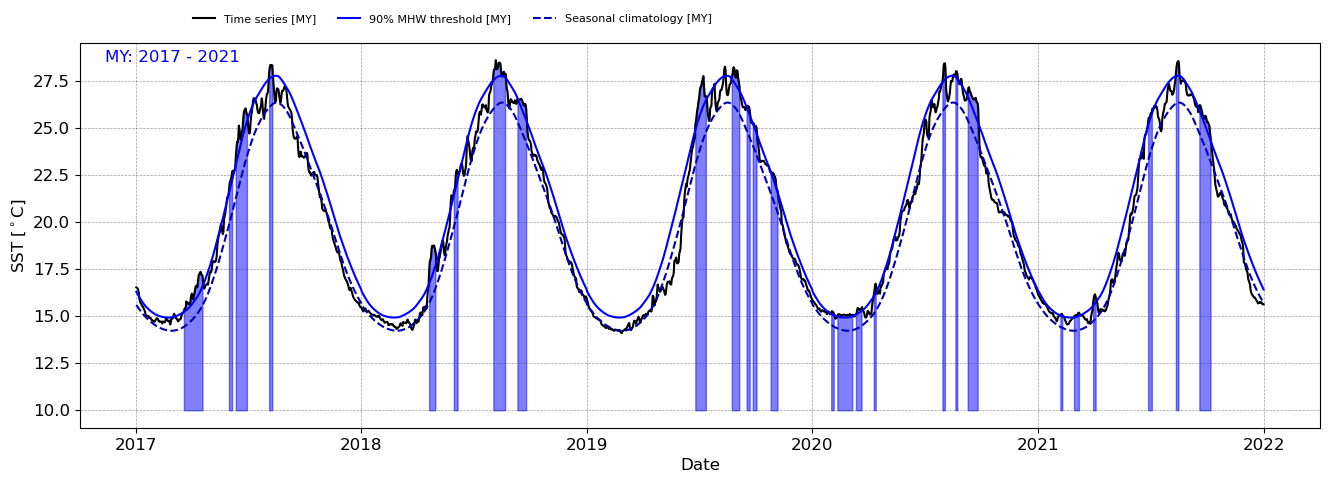

In [21]:
tag = "MY"
series = "2017-2021"

plt.figure(figsize=(16, 5))
plots = []; labels = []; annot = ""

working_dict = heatwaves[tag][series]
clim_dict = heatwaves[tag]["full"]

mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

t_values = np.union1d(mhws.index_start.values, mhws.index_end.values)
y_values = [working_dict["time_series"][int(t)] for t in t_values]

p, = plt.plot(working_dict["time_series"].time, working_dict["time_series"], c = "k")
q, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].thresh[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,1))
r, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].seas[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,0.7), linestyle = "--")
plots.append(p); plots.append(q); plots.append(r)
labels.append(f"Time series [{tag}]"); labels.append(f"90% MHW threshold [{tag}]"); labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

for t1, t2 in zip(*[iter(t_values)]*2):
    plt.fill_between(working_dict["time_series"].time[int(t1):int(t2)], working_dict['time_series'][int(t1):int(t2)], 10, color = 'b', alpha = 0.5)
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.3, 1.10), loc='upper center', ncol=3, fontsize=8)
plt.annotate(annot, (0.02, 0.95), xycoords="axes fraction", color='b')
plt.xlabel(r'Date')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()



**Detail on thresholds**

In Lesson 1 we discussed how increasing the detection threshold for heatwaves could both increase or decrease the number of heatwaves detected in a given time period. We will now see that in action by learning how to adjust the detection threshold in our code.

The `xmhw` package function threshold can be passed a keyword argument `pctile` setting the desired threshold. When this argument is not passed, as we have done up to this point, the default value `pctile = 90` is used. We will compare the effect of a very small change in the detection threshold.

The following cell plots the heatwaves detected between January 2017 and December 2021 using the MY dataset and full climatology using three different detection thresholds stored in the `threshold_percentiles` list parameter: 89%, 90% and 91%.

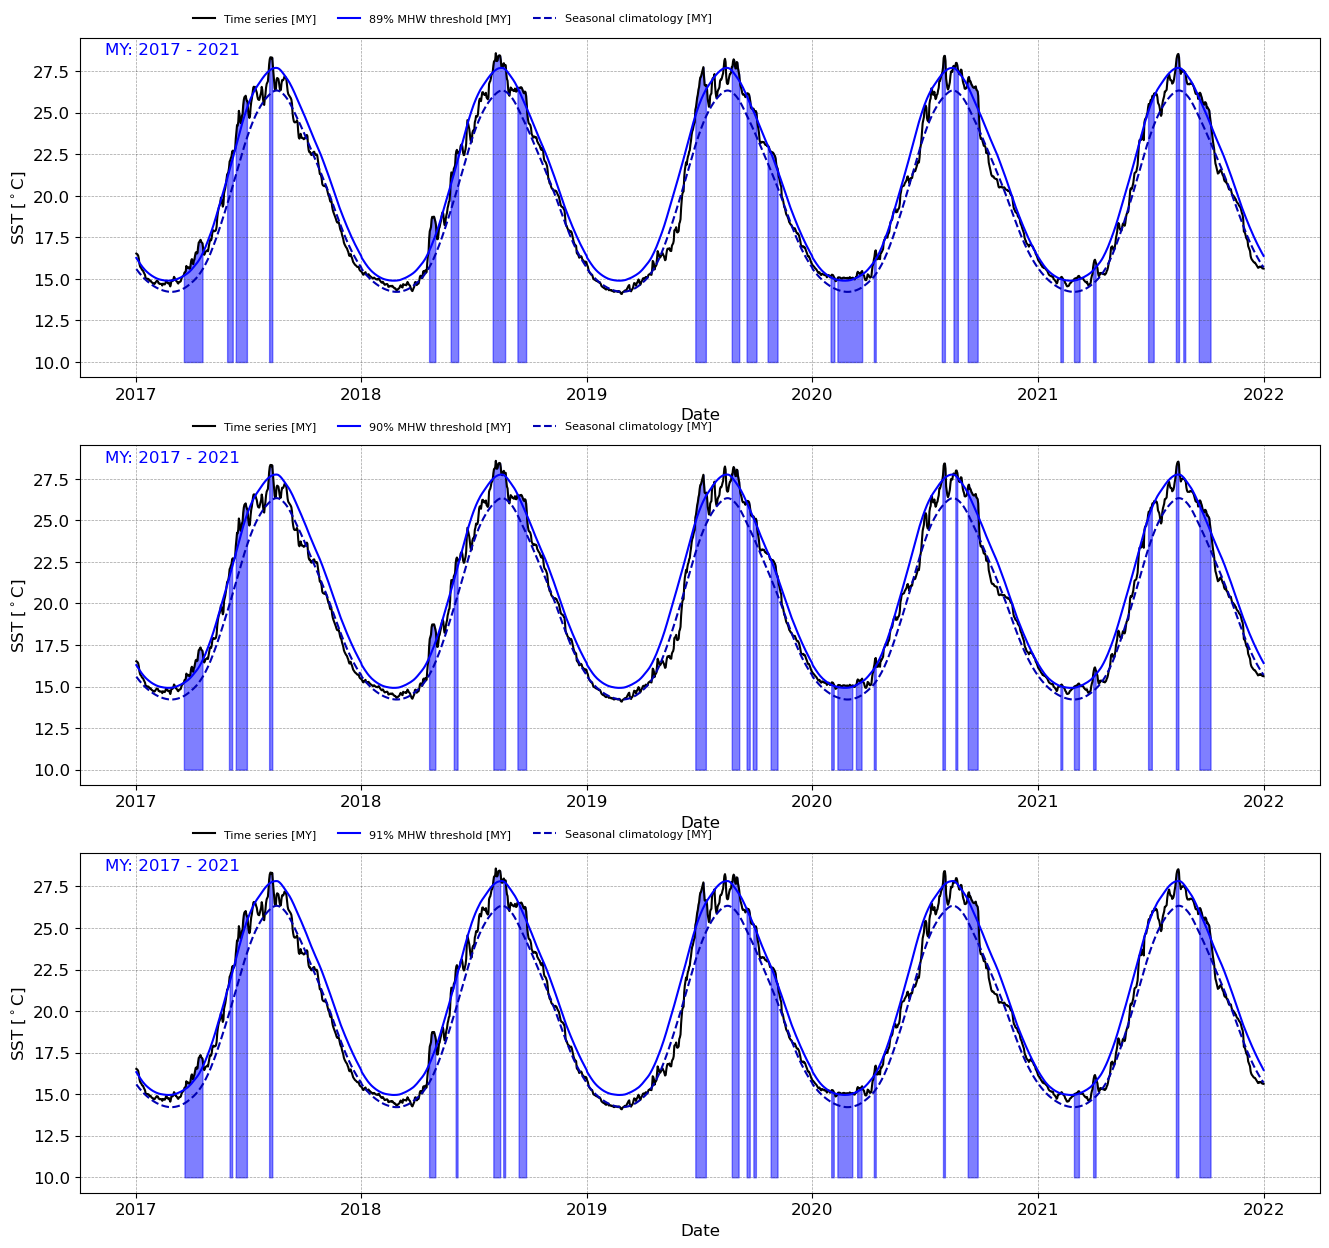

In [22]:
tag = "MY"
series = "2017-2021"

threshold_percentiles = [89,90,91]

gs = gridspec.GridSpec(len(threshold_percentiles), 1)

plt.figure(figsize=(16, 5 * len(threshold_percentiles)))

for i, pctile in enumerate(threshold_percentiles):
    plots = []
    labels = []
    annot = ""

    axes = plt.subplot(gs[i, 0])

    working_dict = heatwaves[tag][series]
    clim_dict = heatwaves[tag]["full"]

    clim = threshold(clim_dict["time_series"], pctile=pctile)

    mhws = detect(working_dict["time_series"], clim.thresh, clim.seas)

    t_values = np.union1d(mhws.index_start.values, mhws.index_end.values)
    y_values = [working_dict["time_series"][int(t)] for t in t_values]

    p, = axes.plot(working_dict["time_series"].time, working_dict["time_series"], c="k")
    q, = axes.plot(working_dict["time_series"].time,
        clim.thresh[working_dict["time_series"].time.dt.dayofyear - 1], c=(0, 0, 1))
    r, = axes.plot(working_dict["time_series"].time,
        clim.seas[working_dict["time_series"].time.dt.dayofyear - 1], c=(0, 0, 0.7), linestyle="--")
    
    plots.append(p)
    plots.append(q)
    plots.append(r)
    labels.append(f"Time series [{tag}]")
    labels.append(f"{pctile}% MHW threshold [{tag}]")
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

    for t1, t2 in zip(*[iter(t_values)] * 2):
        axes.fill_between(
            working_dict["time_series"].time[int(t1) : int(t2)],
            working_dict["time_series"][int(t1) : int(t2)],
            10,
            color="b",
            alpha=0.5,
        )
    axes.grid(color="0.25", linestyle="--", linewidth=0.5, alpha=0.5)
    axes.legend(
        plots,
        labels,
        frameon=False,
        bbox_to_anchor=(0.3, 1.10),
        loc="upper center",
        ncol=3,
        fontsize=8,
    )
    axes.annotate(annot, (0.02, 0.95), xycoords="axes fraction", color="b")
    plt.xlabel(r"Date")
    plt.ylabel(r"SST [$^\circ$C]")

plt.show()

Compare the three outputs.

* How many heatwaves were detected in total in each case?
* As the detection threshold increases, find examples of:
    * A heatwave that turns into two distinct heatwaves;
    * A heatwave that is no longer detected.


Feel free to adjust or add values to the list `threshold_percentiles` and compare different detection thresholds. The size of the plot will automatically update to accommodate all the outputs.

**Detail on MHW detection**

As well as the detection threshold, the definition of marine heatwaves also has two other parameters: minimum duration of temperature exceedance above the threshold, with a default period of 5 days; and a discreteness parameter, with a default of 2 days, which is used to determine if two nearby temperature exceedance events should be counted as one heatwave or multiple.

The `xmhw` package allows for the alteration of the latter two parameters by passing optional keyword arguments to the detect function. Passing the argument `minDuration` changes the duration parameter, and passing the argument `maxGap` changes the discreteness parameter.

The following cell analyses changing the parameter `minDuration`. The list `min_durations` specifies three different values: 4, 5 (default) and 6 days. For each, it computes the heatwaves detected in the 2017 - 2021 period using the MY data over a full reference period, and plots the results.

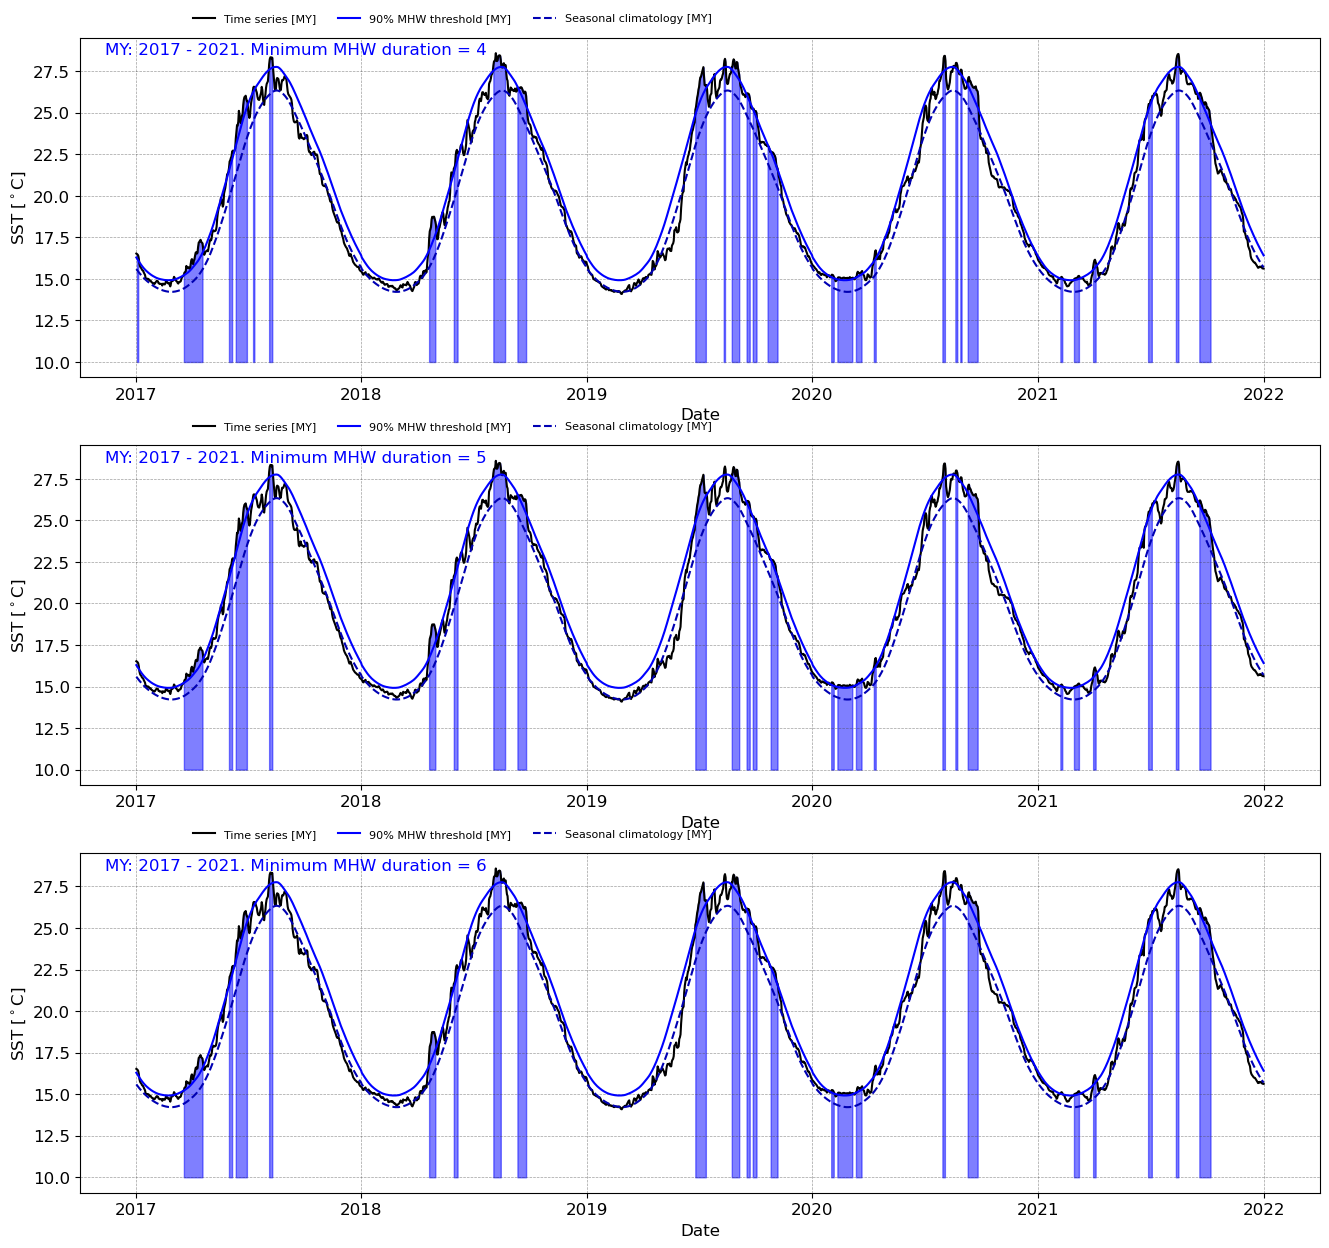

In [23]:
tag = "MY"
series = "2017-2021"

min_durations = [4,5,6]

gs = gridspec.GridSpec(len(min_durations), 1)

plt.figure(figsize=(16, 5 * len(min_durations)))

for i, min_duration in enumerate(min_durations):
    plots = []
    labels = []
    annot = ""

    axes = plt.subplot(gs[i, 0])

    working_dict = heatwaves[tag][series]
    clim_dict = heatwaves[tag]["full"]

    mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas, minDuration= min_duration)

    t_values = np.union1d(mhws.index_start.values, mhws.index_end.values)
    y_values = [working_dict["time_series"][int(t)] for t in t_values]

    p, = axes.plot(working_dict["time_series"].time, working_dict["time_series"], c="k")
    q, = axes.plot(working_dict["time_series"].time,
        clim_dict["xmhw_thresh"].thresh[working_dict["time_series"].time.dt.dayofyear - 1], c=(0, 0, 1))
    r, = axes.plot(working_dict["time_series"].time,
        clim_dict["xmhw_thresh"].seas[working_dict["time_series"].time.dt.dayofyear - 1], c=(0, 0, 0.7), linestyle="--")
    
    plots.append(p)
    plots.append(q)
    plots.append(r)
    labels.append(f"Time series [{tag}]")
    labels.append(f"90% MHW threshold [{tag}]")
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}. " + f"Minimum MHW duration = {min_duration}"

    for t1, t2 in zip(*[iter(t_values)] * 2):
        axes.fill_between(
            working_dict["time_series"].time[int(t1) : int(t2)],
            working_dict["time_series"][int(t1) : int(t2)],
            10,
            color="b",
            alpha=0.5,
        )
    axes.grid(color="0.25", linestyle="--", linewidth=0.5, alpha=0.5)
    axes.legend(
        plots,
        labels,
        frameon=False,
        bbox_to_anchor=(0.3, 1.10),
        loc="upper center",
        ncol=3,
        fontsize=8,
    )
    axes.annotate(annot, (0.02, 0.95), xycoords="axes fraction", color="b")
    plt.xlabel(r"Date")
    plt.ylabel(r"SST [$^\circ$C]")

plt.show()

Analyse the plots as the minimum duration parameter rises.
* How many heatwaves are detected in each case?
* Find an example of a heatwave that is detected with a shorter threshold, but not with a longer one.


Analysing the impact of changing the discreteness parameter can be done in the same way, except instead passing different values of the parameter `maxGap` to the `detect` function.

#### Lesson 5: Comparing marine heatwaves using different data sources

Now that we have developed methods to detect and plot marine heatwaves for a given time series and choice of climatology, we will compare heatwaves detected in the same period using both MY and NRT data, and using climatologies created from the same "common" period of 2007-2021. In doing so, we will show that the definition of marine heatwaves is very sensitive to the choice of data and climatology. Specifically, we will:

* Show that there MHWs detected by one dataset can differ significantly from those detected by another;
* Derive an example of a MHW which is detected from one dataset but not another.

**Quetion: Comparing different data sources**

In the ‘Detecting marine heatwaves’ section of lesson 4, we detected 26 heatwaves over the period 2017-2021 using the MY dataset and climatology taken from the “full” period 1982-2021.
 
**Question 1** Copy the code from the second cell of the ‘Detecting marine heatwaves’ section of lesson 4, which creates the plot. Change the `tag` parameter from `"MY"` to `"NRT"`. This will detect heatwaves over the period 2017-2021 using the NRT dataset and climatology taken from the “full” period 2017-2022. How many heatwaves were detected in total?

**Question 2** Is it possible to conclude that the NRT dataset detects more/fewer heatwaves than the MY dataset? 

**Question 3** One issue is that the climatologies are computed from different reference periods. We’ve let the same bias issues from lesson 3 affect our experiment! Let’s address that. Perform the same two experiments, except change the parameter clim_series_name from `"full"` to `"common"` for each of the two datasets. You should find that the number of heatwaves detected in each case is now the same. How many were there?

**Question 4** Did the two experiments using the “common” climatology period detect the same heatwaves?

**Year-by-year comparison of heatwaves**

We will produce plots to compare  heatwaves detected by MY and NRT data year-by-year. The following cell creates annual time-series slices for the common period 2007-2021 for both datasets.

In [24]:
for year in range(2007, 2022):
    for tag in ["NRT", "MY"]:
        create_TS_slice(tag, f"{year}", year)

Next, for a given year, and for each of the MY and NRT datasets, we will plot the time series, the climatology and thresholds produced from 2007-2021. We will also graphically plot the detected heatwaves from each dataset. The following cell covers the year 2007.

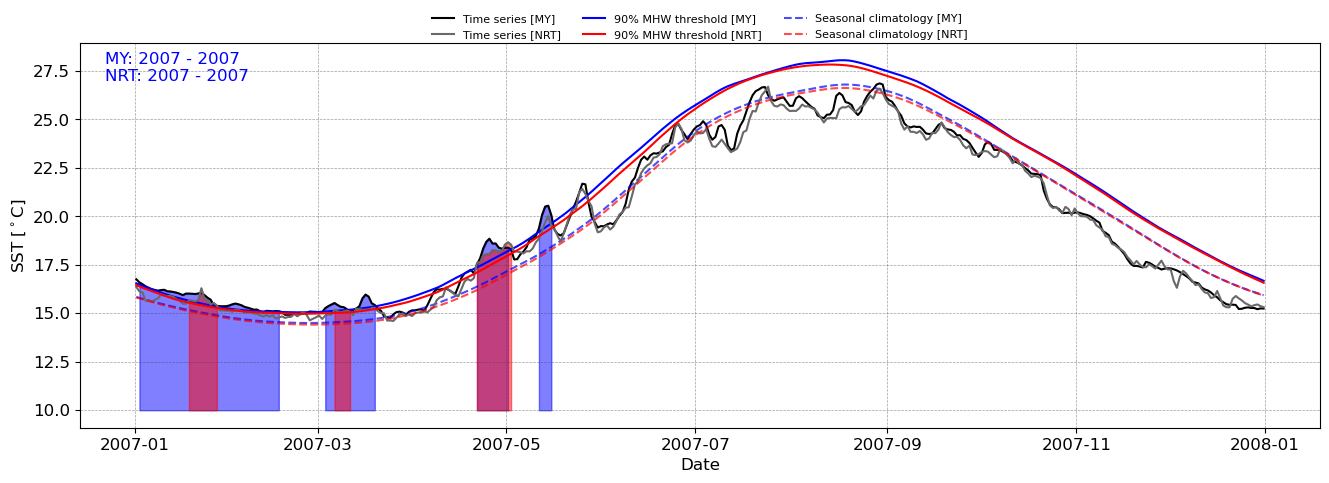

In [25]:
series = 2007

plt.figure(figsize=(16, 5))
plots = []; labels = []; annot = ""

for tag, plot_col, plot_col2 in zip(["MY", "NRT"], ["b", "r"], ["k", "dimgrey"]):
    working_dict = heatwaves[tag][f"{series}"]
    clim_dict = heatwaves[tag]["common"]
    
    mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

    t_values = np.union1d(mhws.index_start.values, mhws.index_end.values)
    y_values = [working_dict["time_series"][int(t)] for t in t_values]

    p, = plt.plot(working_dict["time_series"].time, working_dict["time_series"], c = plot_col2)
    q, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].thresh[working_dict["time_series"].time.dt.dayofyear-1], c = plot_col)
    r, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].seas[working_dict["time_series"].time.dt.dayofyear-1], c = plot_col, alpha = 0.7, linestyle = "--")
    plots.append(p); plots.append(q); plots.append(r)
    labels.append(f"Time series [{tag}]"); labels.append(f"90% MHW threshold [{tag}]"); labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

    #plt.vlines(t_values, 10, y_values, color = 'b', linewidth = 1, zorder = 2)

    for t1, t2 in zip(*[iter(t_values)]*2):
        plt.fill_between(working_dict["time_series"].time[int(t1):int(t2)+1], working_dict['time_series'][int(t1):int(t2)+1], 10, color = plot_col, alpha = 0.5)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend([plots[i] for i in [0,3,1,4,2,5]], [labels[i] for i in [0,3,1,4,2,5]],
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=3, fontsize=8)
plt.annotate(annot, (0.02, 0.9), xycoords="axes fraction", color='b')
plt.xlabel(r'Date')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

The plots may appear cluttered at first, but they provide deep insights. For example, we immediately find an example of a heatwave that is detected from the MY data but not the NRT data, occurring around mid-May.

**Exerise**
By changing the `series` parameter in the previous cell, find:
* an example of the opposite, that is find a year for which the NRT data detects a heatwave, but the MY data does not;
* an example of a year in which both of these happen;
* an example of a year where within the period of a heatwave detected by one dataset, at least two are detected by the other dataset;
* an example of a year in which the same number of heatwaves occur at roughly the same times;
* an example of a year in which the same number of heatwaves occur, but the times are different.

This exercise demonstrates that even when looking at climatologies and time series over the same period, with the same definition of marine heatwaves, there is a lot of variation in what we can detect when comparing two datasets.

#### Lesson 6: Comparing marine heatwaves using different climatologies

The previous lesson showed that the definition of marine heatwaves is very sensitive to the choice of data, even if the way you set climatology and threshold values for that dataset is the same. Therefore great care should be taken not only in ensuring you have accurate and reliable data, but also that you understand if the data you select is suitable for the experiment you want to conduct (spatial resolution, time between samples, and so on).

In this lesson, we will instead fix a dataset and show that there is a similar sensitivity of marine heatwaves to how climatology is defined. By the end, you will:

* Appreciate that different climatologies produced from the same data source affects the detection of MHWs.
* Appreciate that the length of time period used to define climatology can impact the density of heatwaves detected.

**Analysing the density of marine heatwaves detected**

Let's suppose that we've chosen the data source that we want to work with to analyse MHWs. As you may have started to realise in Lesson 4, the detection of heatwaves is still very sensitive to the period of data used to define climatology. To demonstrate this, the following cell calculates all the MHWs detected by the MY data, using climatology based on its full range (1982 - 2021), and plots their density.

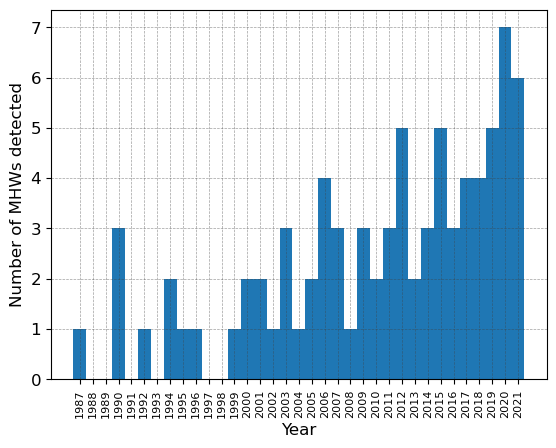

In [26]:
tag = "MY"
series_name = "full"
clim_series_name = "full"

working_dict = heatwaves[tag][series_name]
clim_dict = heatwaves[tag][clim_series_name]

mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

mhw_start_times = mhws.time_start.values.astype("datetime64[D]").tolist()

data = [t.year for t in mhw_start_times]
plt.hist(data, bins = np.arange(min(data),max(data)+2) - 0.5)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(range(min(data),max(data)+1), rotation = 90, fontsize = 8)
plt.xlabel(r'Year')
plt.ylabel(r'Number of MHWs detected')
plt.show()

It would be easy to conclude that the incidence of MHWs has increased over the years, but this plot does not capture the full story because we've already seen in previous lessons that MY data has an upwards trend. Since the detection threshold is the same whether we're looking at heatwaves in 1982 or 2021, we'd expect more heatwave detections when sea temperatures are, on average, higher. Therefore the above density plot may be telling us that the density of heatwaves has increased, or may be telling us nothing new.

**Exercise**

Change the parameter `clim_series_name` in the above cell to `"common"`. This will detect heatwaves in the period 1982-2021 based off of climatology calculated in the period 2007 - 2021. While we again see relatively more heatwaves detected in the second half of the plot, the behaviour is much 'flatter'. Moreover, there are spikes of heatwaves in 2003, 2006 and 2007 which were not as clear the `"full"` plot.

**Reducing the impact of climatic trends on the investigation**

The previous section highlights that comparing heatwaves year to year can be difficult, because upward trends in climate data make it more likely that heatwaves are detected more frequently in recent years. Therefore we must be very careful not to bias our conclusions. When designing your research question, you should be very clear about what you want to investigate, and carefully think about how choosing your data and methods can impact your results.

In this exercise, we will investigate the incidence of heatwaves for a given year using all the available information up to that year, but not beyond. For example, to detect heatwaves in 2007, we will use a climatology generated from the years 1982 up to 2007. As you're working through, note down any issues you think of that might impact conclusions that may be drawn.

To ensure we're using enough data, we begin the experiment in the year 1996, giving us 15 years of data from 1982. The following cell generates all the slices of the MY time series data that we will use, and calculates the appropriate climatology and thresholds.

In [27]:
tag = "MY"

for year in range(1996, 2022):
    series_name = f"up to {year}"
    create_TS_slice(tag, series_name, year-14, year)
    #create_TS_slice(tag, series_name, 1982, year)
    create_TS_slice(tag, f"{year}", year)
    working_dict = heatwaves[tag][series_name]
    working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])
    working_dict["xmhw_detect"] = detect(heatwaves[tag][f"{year}"]["time_series"],working_dict["xmhw_thresh"].thresh, working_dict["xmhw_thresh"].seas)

The following cell then plots a histogram of the results.

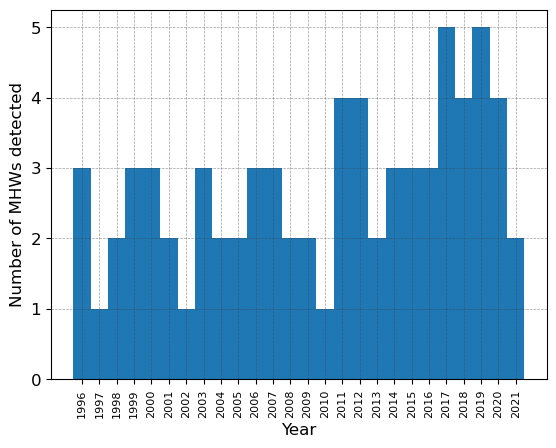

In [28]:
data = []
for year in range(1996,2022):
    series_name = f"up to {year}"
    for i in range(len(heatwaves[tag][series_name]["xmhw_detect"]["time_start"].values)):
        data.append(year)

plt.hist(data, bins = np.arange(min(data),max(data)+2) - 0.5)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(range(min(data),max(data)+1), rotation = 90, fontsize = 8)
plt.xlabel(r'Year')
plt.ylabel(r'Number of MHWs detected')
plt.show()

We do still see an upward trend in the data. What conclusions can we draw?

**Draft of potential further task**

An issue with the previous experiment is that the later years have more data available than earlier years. We could amend this by using 15 year rolling climatology instead.

This relies on stability of time series. We will discuss this further in the next and final lesson.

#### Lesson 7: Stability

**Work in progress:** calculation of successive 15 year trend gradients of MY data.

1982 -- 1996: Trend - R-squared (pvalue): 0.047489 K/year - 0.274834 (0.002011)
1983 -- 1997: Trend - R-squared (pvalue): 0.057745 K/year - 0.374705 (0.000234)
1984 -- 1998: Trend - R-squared (pvalue): 0.047021 K/year - 0.280921 (0.001775)
1985 -- 1999: Trend - R-squared (pvalue): 0.025647 K/year - 0.172663 (0.015246)
1986 -- 2000: Trend - R-squared (pvalue): 0.026746 K/year - 0.184867 (0.012030)
1987 -- 2001: Trend - R-squared (pvalue): 0.031962 K/year - 0.241084 (0.003980)
1988 -- 2002: Trend - R-squared (pvalue): 0.016919 K/year - 0.085403 (0.084413)
1989 -- 2003: Trend - R-squared (pvalue): 0.032308 K/year - 0.188762 (0.011152)
1990 -- 2004: Trend - R-squared (pvalue): 0.025625 K/year - 0.124150 (0.039098)
1991 -- 2005: Trend - R-squared (pvalue): 0.038389 K/year - 0.324896 (0.000704)
1992 -- 2006: Trend - R-squared (pvalue): 0.030409 K/year - 0.247874 (0.003474)
1993 -- 2007: Trend - R-squared (pvalue): 0.031556 K/year - 0.260312 (0.002704)
1994 -- 2008: Trend - R-squared (pvalue)

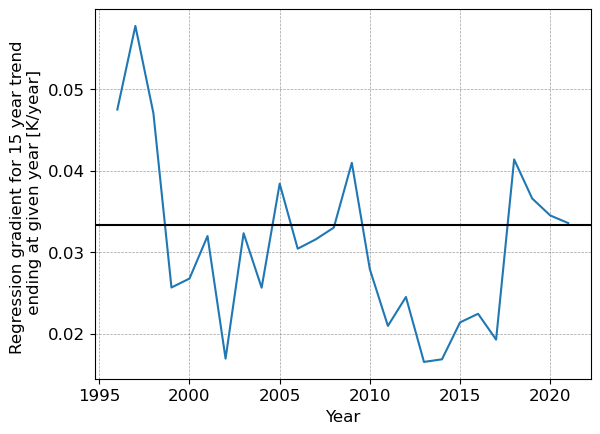

In [29]:
tag = "MY"
gap = 14
TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
plot_x = []; plot_y = []
for clim_start_year in range(1982, 2022-gap):
    DS = xr.open_mfdataset(TS_files).sel(time=slice(f'{clim_start_year}-01-01', f'{clim_start_year + gap}-12-31'))
    DS["timeordinal"]=(['time'],  [pd.to_datetime(x).toordinal() for x in DS.time.values])
    annual = DS.groupby('time.year').mean('time')
    res = stats.linregress(annual.timeordinal, annual.analysed_sst - 273.15)
    print(f"{clim_start_year} -- {clim_start_year + gap}:", f"Trend - R-squared (pvalue): {res.slope*365:.6f} K/year - {res.rvalue**2:.6f} ({res.pvalue**2:.6f})")
    #plt.plot([clim_start_year, clim_start_year + gap], [res.slope*365, res.slope*365])
    plot_x.append(clim_start_year + gap)
    plot_y.append(res.slope*365)
    
plt.plot(plot_x, plot_y)
plt.axhline(0.033366, c="k")
plt.xlabel("Year")
plt.ylabel("Regression gradient for 15 year trend \n ending at given year [K/year]")
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

